# Pylops-distributed - Marchenko redatuming with 3D dataset

### Author: M.Ravasi

This notebook extends the standard *Marchenko* algorithm in PyLops to distibuted computing with dask

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import zarr
import pylops
import pylops_distributed

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.basicoperators import *
from pylops.waveeqprocessing.mdd       import MDC
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.waveeqprocessing.marchenko import directwave
from pylops.utils import dottest

from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.basicoperators import Diagonal as dDiagonal
from pylops_distributed.basicoperators import Identity as dIdentity
from pylops_distributed.basicoperators import Roll as dRoll
from pylops_distributed.waveeqprocessing.mdd import MDC as dMDC
from pylops_distributed.optimization.cg import cg as dcg

In [2]:
os.environ["STORE_PATH"] = ""

In [3]:
#n_workers = 4
#client = pylops_distributed.utils.backend.dask(processes=False, threads_per_worker=1,
#                                               n_workers=n_workers)
#client

In [4]:
n_workers = 4
client = pylops_distributed.utils.backend.dask(hardware='multi', client='be-linrgsn014:8786')
client

Client Scheduler: tcp://be-linrgsn014:8786 Dashboard: http://be-linrgsn014:8787/status,Cluster Workers: 3 Cores: 36 Memory: 414.34 GB


## Inputs

Input parameters 

In [5]:
inputfile_aux = '../data/marchenko/3DMarchenko_auxiliary_2.npz' 
inputfile_data = '../data/marchenko/3DMarchenko_data_samesrcrec.npz' 
zarrfile = os.environ["STORE_PATH"]+'Marchenko3D/input3D.zarr'

vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 10         # iterations
darea = 900         # areal extent for spatial integration

jr = 1              # subsampling in r
js = 1              # subsampling in s

Load input

In [6]:
inputdata_aux = np.load(inputfile_aux)
inputdata = np.load(inputfile_data)

Read and visualize geometry

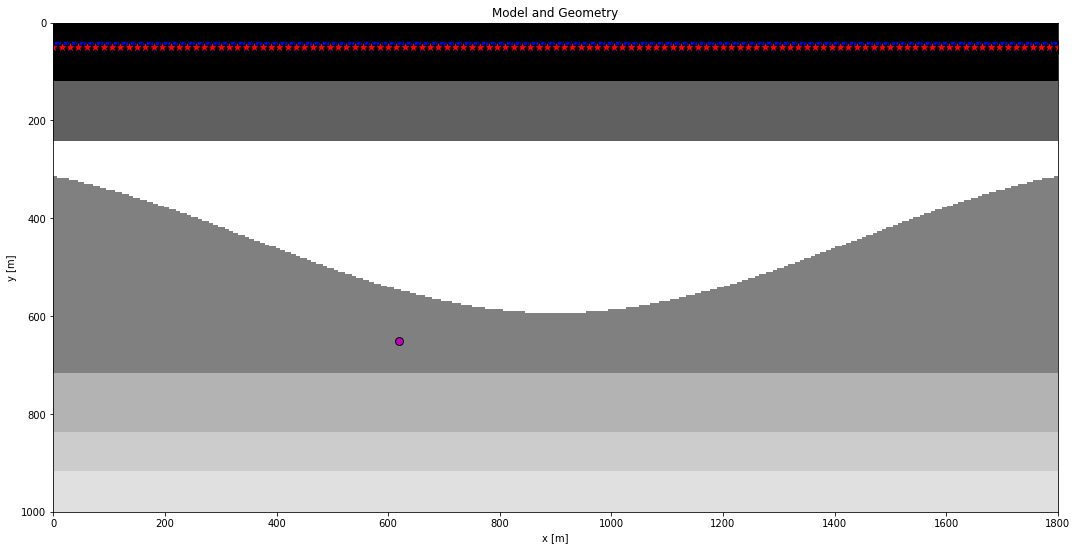

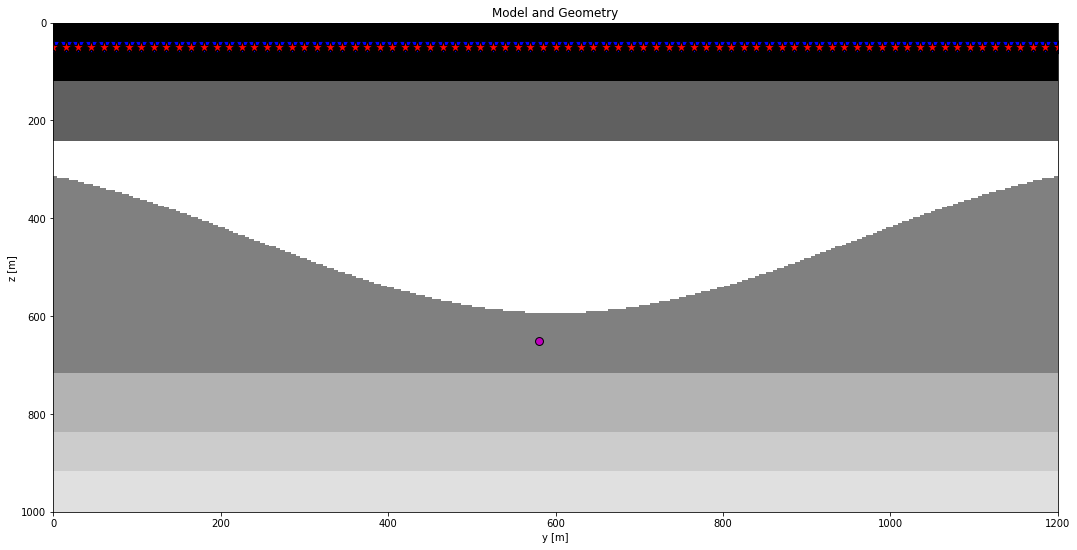

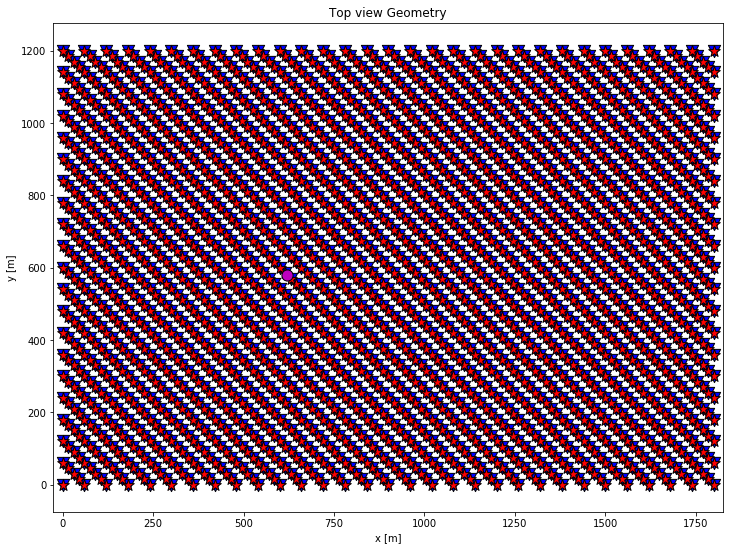

In [7]:
# Receivers
r = inputdata_aux['recs'][::4][::jr].T
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata_aux['srcs'][::4][::jr].T
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata_aux['vs'] # saved wrong!

# Density model
rho = inputdata_aux['rho']
z, x, y = inputdata_aux['z'], inputdata_aux['x'], inputdata_aux['y']

plt.figure(figsize=(18,9))
plt.imshow(rho[np.argmin(np.abs(x-vs[1]))].T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::10],  r[2, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0, 5::10], s[2, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(vs[0], vs[2], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

plt.figure(figsize=(18,9))
plt.imshow(rho[np.argmin(np.abs(y-vs[0]))].T, cmap='gray', extent = (y[0], y[-1], z[-1], z[0]))
plt.scatter(r[1, ::10],  r[2, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[1, 5::10], s[2, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(vs[1], vs[2], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('y [m]'),plt.ylabel('z [m]'),plt.title('Model and Geometry')
plt.xlim(y[0], y[-1]);

plt.figure(figsize=(12,9))
plt.scatter(r[0],  r[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=500, c='m', edgecolors='k')
plt.axis('equal')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Top view Geometry')
plt.xlim(x[0], x[-1]);

Read data

In [8]:
# time axis
ot, dt, nt = 0, 2.5e-3, 601
t = np.arange(nt)*dt

# data
#R = inputdata['data'][::js, ::jr]
#R = np.swapaxes(R, 0, 1)

Read subsurface fields and wavelet to apply to subsurface fields

In [9]:
Gsub = inputdata_aux['G'][:, ::4][:, ::jr]
G0sub = inputdata_aux['G0'][:, ::4][:, ::jr]
wav = ricker(t[:51], 20)[0]
wav_c = np.argmax(wav)

# convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

fig, axs = plt.subplots(3, 1, sharey=True, figsize=(15, 14))
axs[0].imshow(R[20, :200].T, cmap='gray', vmin=-1e-4, vmax=1e-4, 
              extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, 0)
axs[1].imshow(R[ns//2, ns//2-100:ns//2+100].T, cmap='gray', vmin=-1e-4, vmax=1e-4,
              extent=(0, nr, t[-1], t[0]))
axs[1].set_title('R shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, 0)
axs[2].imshow(R[-20, -200:].T, cmap='gray', vmin=-1e-4, vmax=1e-4, 
              extent=(0, nr, t[-1], t[0]))
axs[2].set_title('R shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(1, 0)

fig, axs = plt.subplots(2, 1, sharey=True, figsize=(15, 10))
axs[0].imshow(Gsub[:, ns//2-100:ns//2+100], cmap='gray', vmin=-1e3, vmax=1e3, 
              extent=(0, nr, t[-1], t[0]))
axs[0].set_title('G'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, 0)
axs[1].imshow(G0sub[:, ns//2-100:ns//2+100], cmap='gray', vmin=-1e3, vmax=1e3, 
              extent=(0, nr, t[-1], t[0]))
axs[1].set_title('G0'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(1, 0);

## Marchenko preparation

Create window

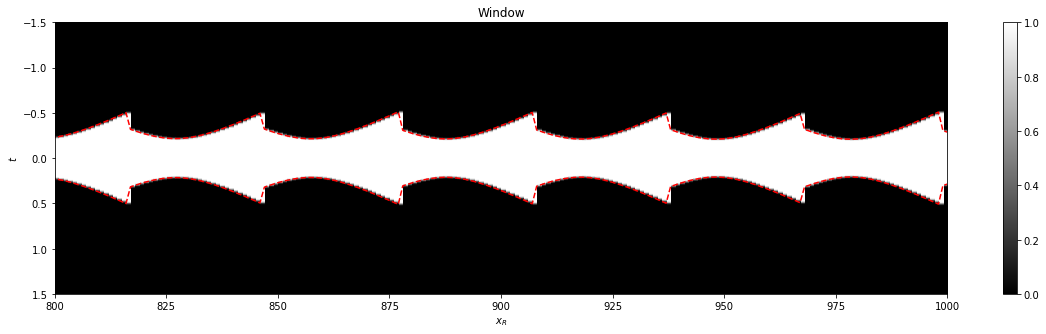

In [10]:
# direct arrival window - traveltime
directVS = np.sqrt((vs[0]-r[0])**2 +(vs[1]-r[1])**2 +(vs[2]-r[2])**2)/vel
directVS_off = directVS - toff

# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((np.fliplr(w), w[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    
    
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(20, 5))
im = ax.imshow(w.T, cmap='gray', extent=(0, nr, t[-1], -t[-1]))
ax.plot(np.arange(0, nr), directVS_off, '--r')
ax.plot(np.arange(0, nr), -directVS_off, '--r')
ax.set_title('Window') 
ax.set_xlabel(r'$x_R$')
ax.set_ylabel(r'$t$')
ax.axis('tight')
ax.set_xlim(800, 1000);
fig.colorbar(im, ax=ax);

Create analytical direct wave **(Need to write 3D analytical)**

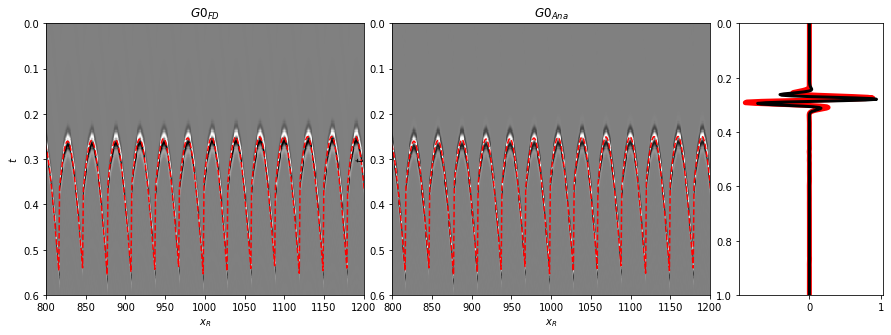

In [11]:
#G0sub_ana = directwave(wav, directVS, nt, dt, nfft=2**11) 
G0sub_ana = directwave(np.diff(wav), directVS, nt, dt, nfft=2**11) 

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(G0sub/G0sub.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(0, nr, t[-1], t[0]))
ax1.set_title(r'$G0_{FD}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.plot(np.arange(0, nr), directVS, '--r')
ax1.axis('tight')
ax1.set_ylim(.6, 0)
ax1.set_xlim(800, 1200)
ax2.imshow(G0sub_ana/G0sub_ana.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(0, nr, t[-1], t[0]))
ax2.set_title(r'$G0_{Ana}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.plot(np.arange(0, nr), directVS, '--r')
ax2.axis('tight')
ax2.set_ylim(.6, 0)
ax2.set_xlim(800, 1200)
ax3.plot(G0sub[:, nr//2-10]/G0sub.max(), t, 'r', lw=5)
ax3.plot(G0sub_ana[:, nr//2-10]/G0sub_ana.max(), t, 'k', lw=3)
ax3.set_ylim(1., 0);

For now we will use the direct wave obtained via finite-difference, but we will show later that Marchenko redatuming can converge to the correct solution also when using an analytical direct wave.

## Inversion

Read it directly from Zarr file created in ``Zarr.ipynb`` notebook

In [12]:
dRtwosided_fft = 2 * da.from_zarr(zarrfile)  # 2 * as per theory you need 2*R
#dRtwosided_fft = client.persist(dRtwosided_fft)
dRtwosided_fft

dask.array<mul, shape=(500, 2451, 2451), dtype=complex64, chunksize=(25, 2451, 2451)>

Create distributed Marchenko operator

In [13]:
# Operators
dRop = dMDC(dRtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=darea, twosided=True, todask=(True, True))
dR1op = dMDC(dRtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=darea, twosided=True, conj=True, todask=(True, True))
dRollop = dRoll((2*nt-1) * nr,
               dims=(2*nt-1, nr),
               dir=0, shift=-1)

# Input focusing function
dfd_plus =  np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr))))
dfd_plus = da.from_array(dfd_plus)

In [14]:
dfd_plus

dask.array<array, shape=(1201, 2451), dtype=float64, chunksize=(1201, 2451)>

In [15]:
dWop = dDiagonal(w.T.flatten())
dIop = dIdentity(nr*(2*nt-1))

dMop = pylops_distributed.VStack([pylops_distributed.HStack([dIop, -1*dWop*dRop]),
                                 pylops_distributed.HStack([-1*dWop*dRollop*dR1op, dIop])])*pylops_distributed.BlockDiag([dWop, dWop])
dGop = pylops_distributed.VStack([pylops_distributed.HStack([dIop, -1*dRop]),
                                 pylops_distributed.HStack([-1*dRollop*dR1op, dIop])])

ddottest(dGop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), chunks=(2*nr*(2*nt-1), 2*nr*(2*nt-1)), verb=True)
ddottest(dMop, 2*nr*(2*nt-1), 2*nr*(2*nt-1), chunks=(2*nr*(2*nt-1), 2*nr*(2*nt-1)), verb=True)

Dot test passed, v^T(Opu)=1337160.229257 - u^T(Op^Tv)=1337160.229257
Dot test passed, v^T(Opu)=288954.823755 - u^T(Op^Tv)=288954.823755


True

Run standard redatuming as benchmark

In [16]:
dp0_minus = dRop * dfd_plus.flatten()
dp0_minus = dp0_minus.reshape((2*nt-1), nr).T

In [17]:
dp0_minus

dask.array<transpose, shape=(2451, 1201), dtype=float64, chunksize=(2451, 1201)>

Create data

In [18]:
dd = dWop*dRop*dfd_plus.flatten()
dd = da.concatenate((dd.reshape(2*nt-1, nr), da.zeros((2*nt-1, nr))))

In [19]:
dd

dask.array<concatenate, shape=(2402, 2451), dtype=float64, chunksize=(1201, 2451)>

Adjoint and inverse focusing functions

In [20]:
df1_adj = dMop.H * dd.flatten()
df1_inv = dcg(dMop.H * dMop, dMop.H * dd.ravel(), 
              niter=10, compute=False)

df1_adj = df1_adj.reshape(2*(2*nt-1), nr)
df1_inv = df1_inv.reshape(2*(2*nt-1), nr)

Add initial guess to estimated focusing functions

In [21]:
df1_adj_tot = df1_adj + da.concatenate((da.zeros((2*nt-1, nr)),
                                        da.concatenate((da.fliplr(G0sub.T).T,
                                                        da.zeros((nt-1, nr))), axis=0)))

df1_inv_tot = df1_inv + da.concatenate((da.zeros((2*nt-1, nr)), 
                                        dfd_plus))

Estimate Green's functions

In [22]:
dg_adj = dGop * df1_adj_tot.flatten()
dg_inv = dGop * df1_inv_tot.flatten()

dg_adj = dg_adj.reshape(2*(2*nt-1), nr)
dg_inv = dg_inv.reshape(2*(2*nt-1), nr)

In [23]:
dd, dp0_minus, df1_adj_tot, df1_inv_tot, dg_adj, dg_inv = \
    da.compute(dd, dp0_minus, df1_adj_tot, df1_inv_tot, dg_adj, dg_inv)

Extract up and down focusing and Green's functions from model vectors

In [24]:
# need to understand why...
dg_adj = np.real(dg_adj)
dg_inv = np.real(dg_inv)

In [25]:
df1_adj_minus, df1_adj_plus = df1_adj_tot[:(2*nt-1)].T, df1_adj_tot[(2*nt-1):].T
df1_inv_minus, df1_inv_plus = df1_inv_tot[:(2*nt-1)].T, df1_inv_tot[(2*nt-1):].T

dg_adj_minus, dg_adj_plus =  -dg_adj[:(2*nt-1)].T, np.fliplr(dg_adj[(2*nt-1):].T)
dg_inv_minus, dg_inv_plus =  -dg_inv[:(2*nt-1)].T, np.fliplr(dg_inv[(2*nt-1):].T)

dg_inv_tot = dg_inv_minus + dg_inv_plus

Visualization

In [26]:
# Need to recreate combined data as new implementation stacks over time instead of space
dd = np.concatenate((dd[:(2*nt-1)], dd[(2*nt-1):]), axis=1).T
df1_adj_tot = np.concatenate((df1_adj_tot[:(2*nt-1)], df1_adj_tot[(2*nt-1):]), axis=1).T
df1_inv_tot = np.concatenate((df1_inv_tot[:(2*nt-1)], df1_inv_tot[(2*nt-1):]), axis=1).T
dg_adj = np.concatenate((dg_adj[:(2*nt-1)], dg_adj[(2*nt-1):]), axis=1).T
dg_inv = np.concatenate((dg_inv[:(2*nt-1)], dg_inv[(2*nt-1):]), axis=1).T

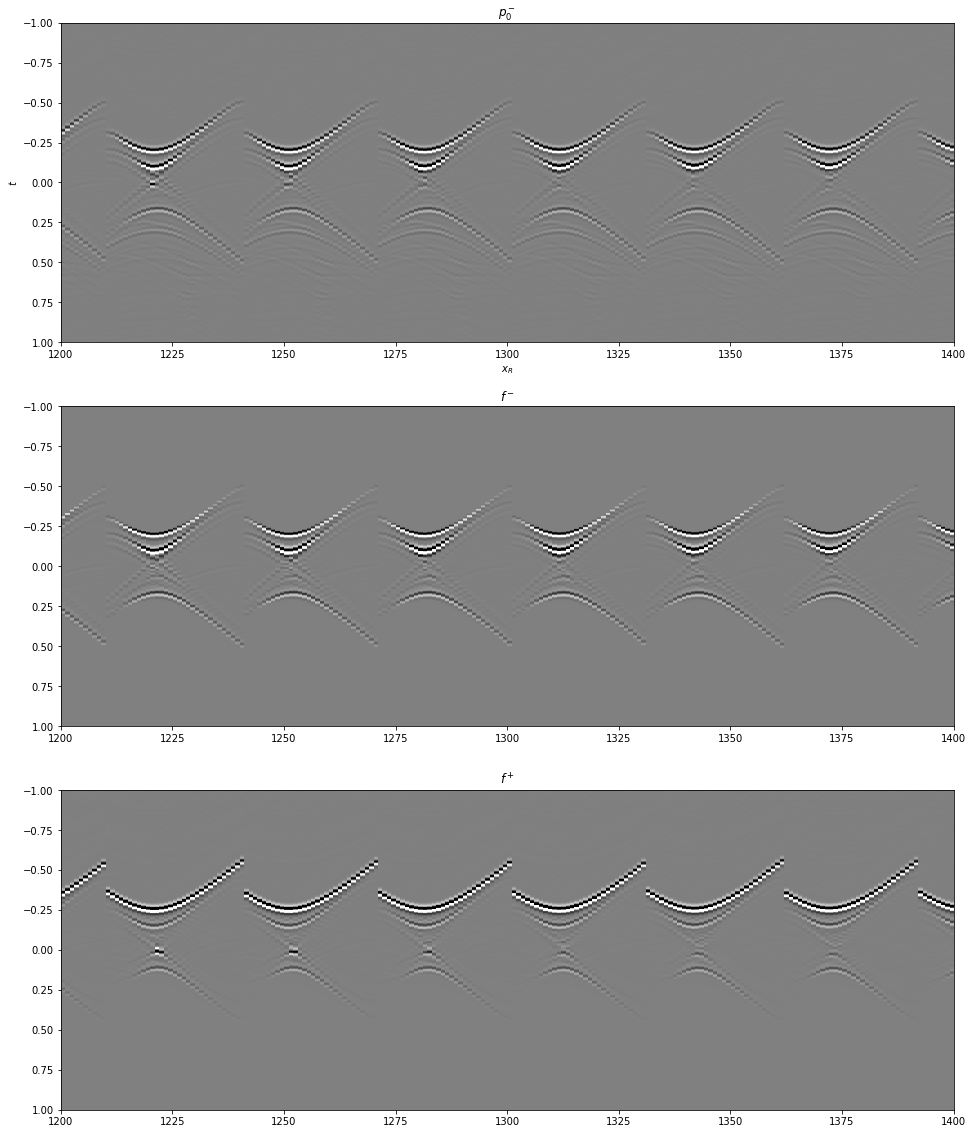

In [27]:
fig, axs = plt.subplots(3, 1, sharey=True, figsize=(16, 20))
axs[0].imshow(dp0_minus.T, cmap='gray', vmin=-6e3, vmax=6e3, extent=(0, nr, t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_xlim(1200,1400)
axs[0].set_ylim(1, -1)
axs[1].imshow(df1_inv_minus.T, cmap='gray', vmin=-6e3, vmax=6e3, extent=(0, nr, t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_xlim(1200,1400)
axs[1].set_ylim(1, -1)
axs[2].imshow(df1_inv_plus.T, cmap='gray', vmin=-6e3, vmax=6e3, extent=(0, nr, t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_xlim(1200,1400)
axs[2].set_ylim(1, -1);

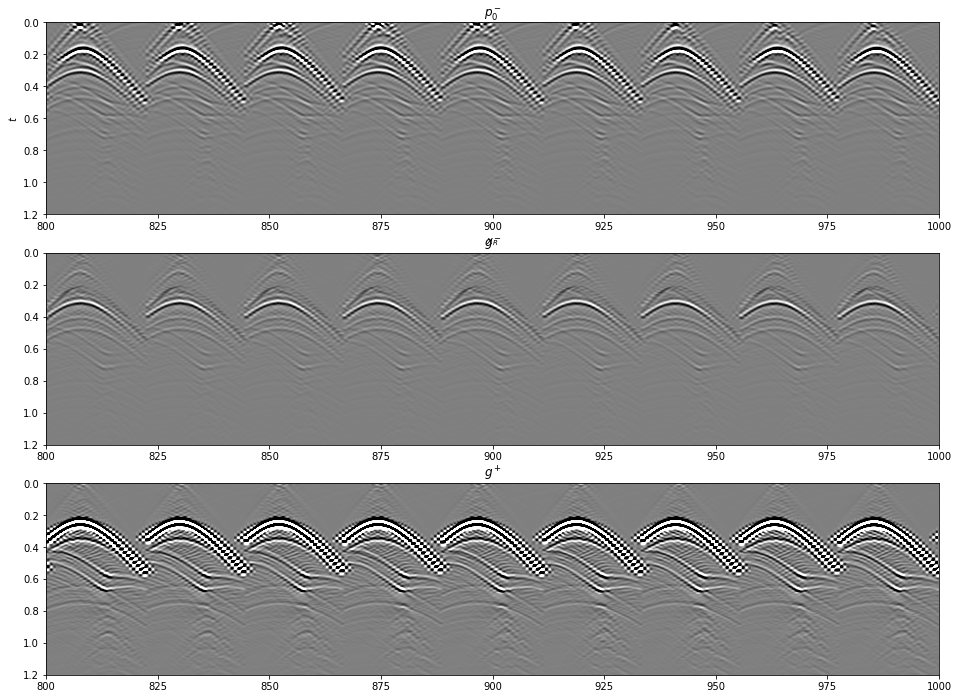

In [28]:
fig, axs = plt.subplots(3, 1, sharey=True, figsize=(16, 12))
axs[0].imshow(dp0_minus.T, cmap='gray', vmin=-1e3, vmax=1e3, 
              interpolation='sinc', extent=(0, nr, t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.2, 0)
axs[0].set_xlim(800, 1000)
axs[1].imshow(dg_inv_minus.T, cmap='gray', vmin=-1e3, vmax=1e3, 
              interpolation='sinc', extent=(0, nr, t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.2, 0)
axs[1].set_xlim(800, 1000)
axs[2].imshow(dg_inv_plus.T, cmap='gray', vmin=-1e3, vmax=1e3, 
              interpolation='sinc', extent=(0, nr, t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.2, 0)
axs[2].set_xlim(800, 1000);

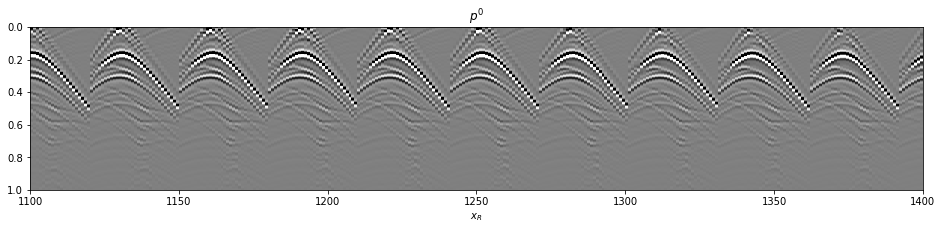

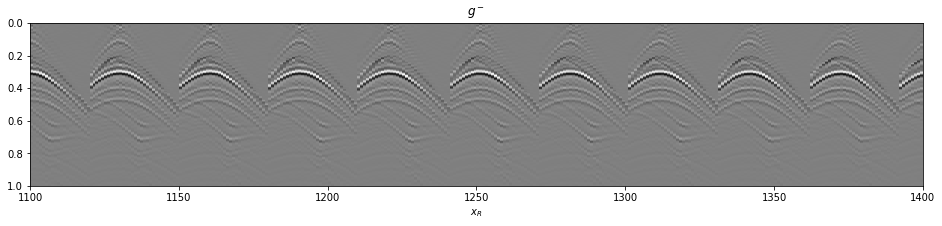

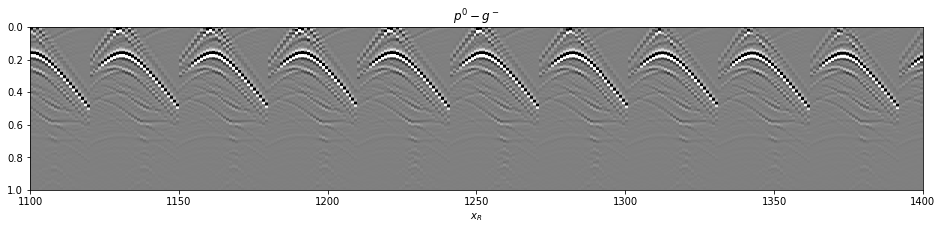

In [31]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(16, 3))
ax.imshow(dp0_minus.T, cmap='gray', vmin=-1e3, vmax=1e3, 
          extent=(0, nr, t[-1], -t[-1]))
ax.set_title(r'$p^0$'), ax.set_xlabel(r'$x_R$')
ax.axis('tight')
ax.set_ylim(1., 0)
ax.set_xlim(1100, 1400)

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(16, 3))
ax.imshow(dg_inv_minus.T, cmap='gray', vmin=-1e3, vmax=1e3, 
          extent=(0, nr, t[-1], -t[-1]))
ax.set_title(r'$g^-$'), ax.set_xlabel(r'$x_R$')
ax.axis('tight')
ax.set_ylim(1., 0)
ax.set_xlim(1100, 1400);

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(16, 3))
ax.imshow(dp0_minus.T - dg_inv_minus.T, cmap='gray', vmin=-1e3, vmax=1e3, 
          extent=(0, nr, t[-1], -t[-1]))
ax.set_title(r'$p^0 - g^-$'), ax.set_xlabel(r'$x_R$')
ax.axis('tight')
ax.set_ylim(1., 0)
ax.set_xlim(1100, 1400);

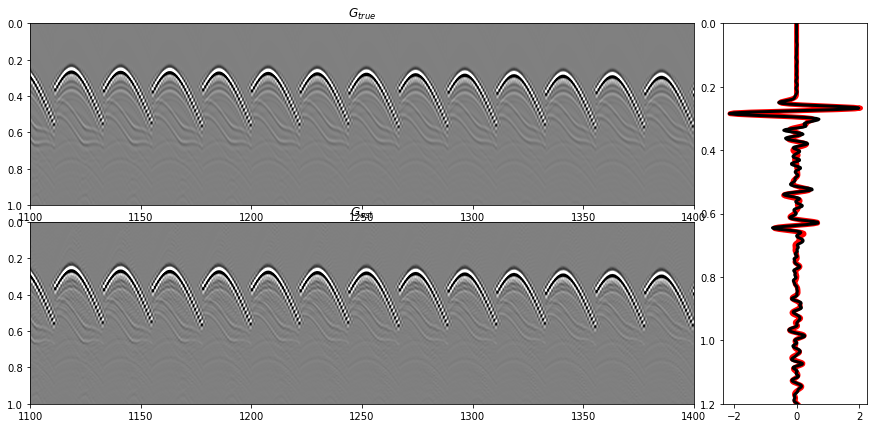

In [30]:
fig = plt.figure(figsize=(15, 7))
ax1 = plt.subplot2grid((4, 5), (0, 0), rowspan=2, colspan=4)
ax2 = plt.subplot2grid((4, 5), (2, 0), rowspan=2, colspan=4)
ax3 = plt.subplot2grid((4, 5), (0, 4), rowspan=4)

ax1.imshow(Gsub, cmap='gray', vmin=-5e3, vmax=5e3, extent=(0, nr, t[-1], t[0]),
           interpolation='sinc')
ax1.set_title(r'$G_{true}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1., 0)
ax1.set_xlim(1100, 1400)
ax2.imshow(dg_inv_tot.T, cmap='gray', vmin=-5e3, vmax=5e3, extent=(0, nr, t[-1], -t[-1]),
           interpolation='sinc')
ax2.set_title(r'$G_{est}$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1., 0)
ax2.set_xlim(1100, 1400)

ax3.plot(np.exp(3*t) * Gsub[:, nr//2]/Gsub.max(), t, 'r', lw=5)
ax3.plot(np.exp(3*t) * dg_inv_tot[nr//2, nt-1:]/dg_inv_tot.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);